In [CurveSensitivity.py](CurveSensitivity.py) I generate Fake Michaelis Menten data - first Kds and vmax's from a uniform distribution, then I make a set of fake points using a K value (also from a uniform distribution) and add some random noise (from a normal distribution (0,Noise) where noise was selected from a uniform dist. Then I try to fit my Michaelis Menten curve and get back my predicted Kd, Vmax and R squared

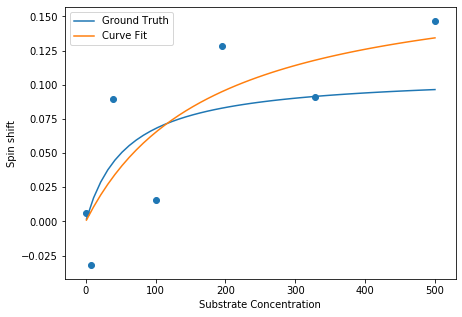

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CurveSensitivity import GenerateMichaelisMenten, FitMichaelisMenten


'''
Example of how I generated the data:
'''
kd, vmax ,noise, k, npoints =  np.random.uniform(0,100),  np.random.uniform(0,1),  \
np.random.uniform(0,0.1), np.random.uniform(1,4), np.random.randint(1,10)

x,y = GenerateMichaelisMenten(kd, vmax ,noise, k,npoints)
kd_pred, vmax_pred, loss = FitMichaelisMenten(x,y)

plt.figure(figsize = (7,5))
x_ = np.linspace(1,500,50)
plt.plot(x_, (vmax*x_)/(kd + x_))
plt.scatter(x,y)
plt.plot(x_, (vmax_pred*x_)/(kd_pred + x_))
plt.xlabel('Substrate Concentration')
plt.ylabel('Spin shift')
plt.legend(['Ground Truth','Curve Fit'])
plt.show()

100%|██████████| 50/50 [00:16<00:00,  3.19it/s]


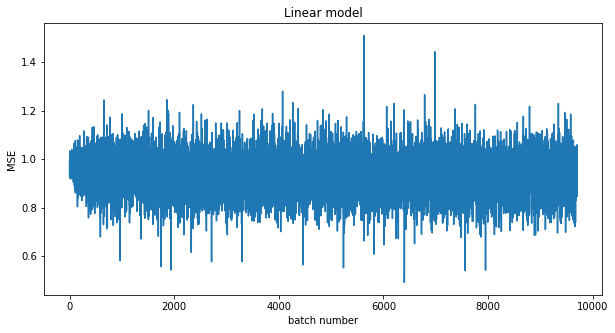

  0%|          | 0/50 [00:00<?, ?it/s]

test loss =  0.9424901008605957


100%|██████████| 50/50 [00:16<00:00,  2.86it/s]


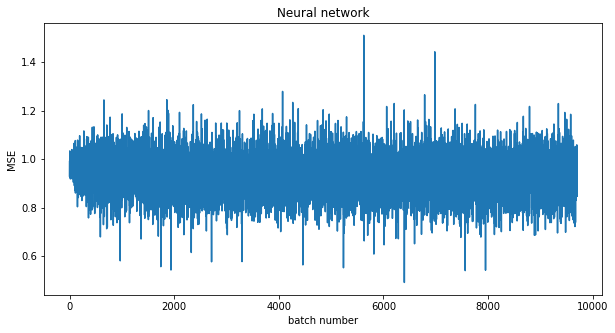

test loss =  0.9690392017364502


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# get data
x = pd.read_csv('MonteCarloMichaelisMenten_x.csv',index_col = 0)
y = pd.read_csv('MonteCarloMichaelisMenten_y.csv',index_col = 0)
y.dropna(inplace = True)
y = y.loc[:,['Kd']]
x = x.loc[y.index,:]

#Normalize
normalizer = Normalizer()
y = normalizer.fit_transform(y)
x = normalizer.fit_transform(x)

#split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)



x_train, x_test, y_train, y_test = torch.tensor(x_train,dtype=torch.float),\
torch.tensor(x_test,dtype=torch.float), \
torch.tensor(y_train,dtype=torch.float), \
torch.tensor(y_test,dtype=torch.float)

# Data loader
class dataset(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

train_loader = DataLoader(dataset=dataset(x_train,y_train),
                          batch_size=32,
                          shuffle=True,
                          num_workers=1)

#define models
lin = nn.Linear(x.shape[1],1)


model = nn.Sequential(nn.Linear(x.shape[1],8),
                     nn.ReLU(),
                     nn.Linear(8,8),
                     nn.ReLU(),
                     nn.Linear(8,1),
                     nn.Sigmoid())



def train(train_loader, model,epochs):
    opt = torch.optim.SGD(model.parameters(),lr = 1e-3)
    loss_fn = nn.MSELoss()
    loss_record = []
    for epoch in tqdm(range(epochs)):
        for _,i in enumerate(train_loader):
            x_batch, y_batch = i[0], i[1]
            y_pred = model.forward(x_batch)
            loss = loss_fn(y_batch.reshape(-1,1),y_pred)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_record.append(loss.item())
    return loss_record

lin_loss_record = train(train_loader, lin, epochs = 50)
plt.figure(figsize = (10,5))
plt.plot(np.array(lin_loss_record))
plt.title('Linear model')
plt.xlabel('batch number')
plt.ylabel('MSE')
plt.show()
#evaluate
loss_fn = nn.MSELoss() # need this as a globabl variable
print('test loss = ',loss_fn(y_test,lin.forward(x_test)).item())


nn_loss_record = train(train_loader, model, epochs = 50)
plt.figure(figsize = (10,5))
plt.plot(np.array(lin_loss_record))
plt.title('Neural network')
plt.xlabel('batch number')
plt.ylabel('MSE')
plt.show()
#evaluate
loss_fn = nn.MSELoss() # need this as a globabl variable
print('test loss = ',loss_fn(y_test,model.forward(x_test)).item())